In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pickle as pkl
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import dLdp
from utils.regions import CircleExterior
from tracking_log import logger

# style.use('')

%load_ext autoreload
%autoreload 2

## System Communication Schema


![System Communication Schema](Schema.png)


## Main Loop 

In [2]:
from utils.regions import Rect2D




In [3]:
def main(n_sensors,std,boundary_radius,bhat = -2,khat=1,moving=True,epsilon=0.5):
    # Set up mobile sensors and sources
    src_locs = [[6.,6]]
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    
    
    initial_locs = random_initial_poses(n_sensors,xmin=0,xmax=3,ymin=0,ymax=3)
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]
    # Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    vs = virtual_sensor(C1,C0,b,k,std)

    # Set up location estimator
    n_sen = len(mobile_sensors)
    n_src = len(source)

    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = khat * np.ones(n_sen)# Inaccurate k
    bs = bhat *np.ones(n_sen) # Inaccurate b
    initial_guess = np.array([4.,2.])
    xlim = (-np.inf,np.inf)
    ylim = (-np.inf,np.inf)

    estimator = getDynamicFilter(len(mobile_sensors),len(source),C1s,C0s,ks,bs,initial_guess,filterType="ekf",xlim=xlim,ylim=ylim)
    estimator_name = 'ekf'


    # Set up waypoint planner
    f_dLdp=dLdp(C1s=C1s,C0s=C0s,ks=ks,bs=bs)
    planning_timesteps = 1
    max_linear_speed = 0.22
    planning_dt = 1
    epsilon = 0.1
    # The FIM waypoint planning  
    fplan = lambda qs,ps:FIM_ascent_path_planning(f_dLdp,qs,ps,n_sen,\
                    planning_timesteps,\
                    max_linear_speed,\
                    planning_dt,\
                    epsilon,\
                    # Rect2D(self.xlim,self.ylim))
                    CircleExterior(np.array([6,6]),boundary_radius))

    # Set up data logger
    log = logger(sensor_names,src_names)

    # Enter main loop

    N = 40
    reach_time = np.inf
    for _ in range(N):
        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
        y = vs.measurement(qs,ps)

        # Estimate
        qhat = estimator.update_and_estimate_loc(ps,y)


         # Record
        for s in source:
            log.est_locs_log[estimator_name].append(qhat)
            log.src_locs[s.name].append(s.loc)
        
        for m in mobile_sensors:
            log.sensor_locs[m.name].append(m.loc)
        
        if np.any(np.linalg.norm(ps-qs,axis=1)<=epsilon) and reach_time==np.inf: # Terminal condition reached, do not move sensors.
            reach_time = _
        if moving:
        
            #Plan 
            waypoints = fplan(qhat,ps)

            # Move
            for i in range(n_sen):
                mobile_sensors[i].update_loc(waypoints[0][i])
    return log,reach_time
def get_err(log):
    for key,est_locs in log['est_locs_log'].items():
        if key in["ekf"]:            
            target_locs = log['src_locs']['source_1']
            l = np.min([len(target_locs),len(est_locs)])
            target_locs = target_locs[:l]
            est_locs = est_locs[:l]
            target_locs = target_locs[~(np.isnan(est_locs))].reshape(-1,2)
            est_locs = est_locs[~(np.isnan(est_locs))].reshape(-1,2)
            
            if len(est_locs)>0:
                err = np.linalg.norm(est_locs-target_locs,axis = 1)
                return err

def random_initial_poses(n_sensors,xmin,xmax,ymin,ymax):
    sensor_poses = np.zeros((n_sensors,2))
    sensor_poses[:,0]= xmin + np.random.rand(n_sensors)*(xmax-xmin)
    sensor_poses[:,1]= ymin + np.random.rand(n_sensors)*(ymax-ymin)
    return sensor_poses

In [5]:
Ns =[10]
errs = {}
noise_std = 0.01
N_trails= 100
boundary_r = 0.0
dbs = np.array([-0.5,-0.1,0,0.1,0.5])
reach_times = {}
# for n_sensor in Ns:
#     for db in dbs:
#         print("db = {}".format(db))
#         errs[db] = []
#         reach_times[db]=[]
#         for _ in range(N_trails):
#             print("{}/{} finished".format(_,N_trails))
#             bhat = -2+db
#             log,t = main(n_sensor,noise_std,boundary_r,bhat)
#             record = log.export()
#             errs[db].append(get_err(record))
#             reach_times[db].append(t)

In [137]:

filepath = "RobustnessMoving.pkl".format(noise_std)
with open(filepath,'wb') as file:
    pkl.dump([errs,reach_times],file)

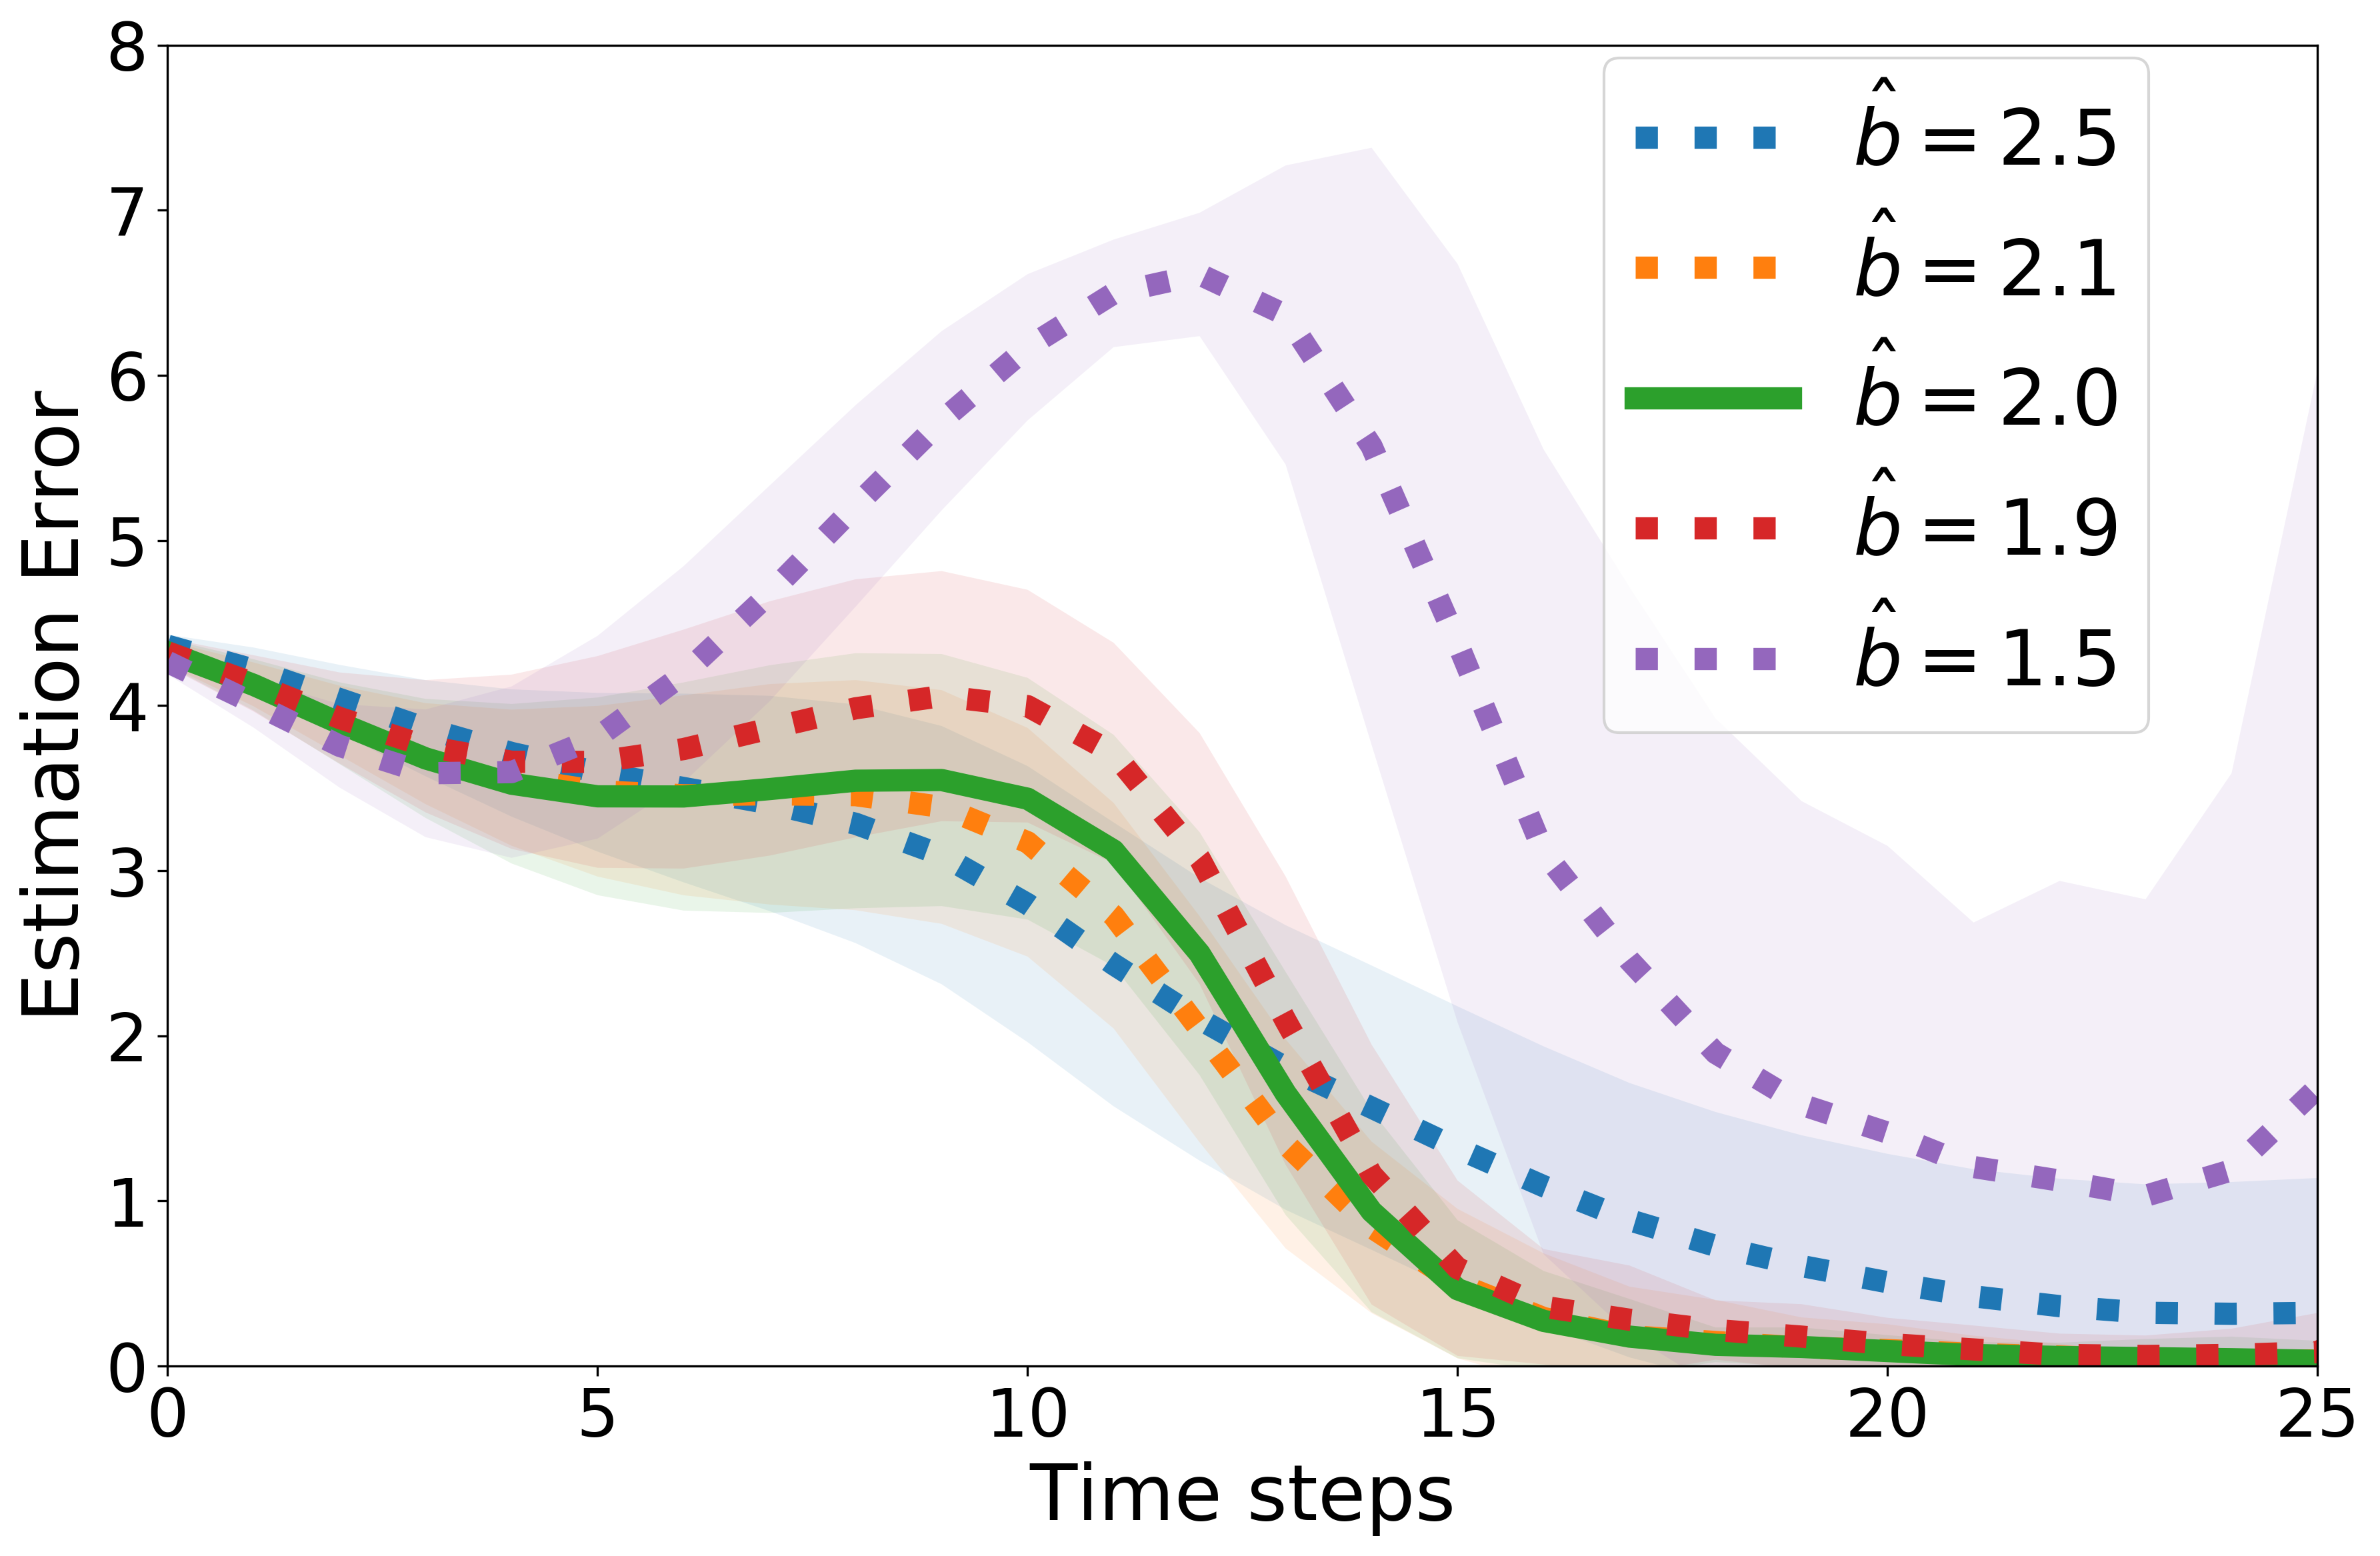

In [15]:
filepath = "RobustnessMoving.pkl"
with open(filepath,'rb') as file:
    errs,reach_times = pkl.load(file)
plt.figure(dpi=300,figsize=(12,8))
# plt.figure(dpi=200,figsize=(12,8))
for db,err in errs.items():
#     if db!=-0.1:
        mse = np.mean(err,axis=0)
#         mse = mse[:25]
        std = np.std(err,axis=0)
#         std = std[:25]
        x = range(len(mse))
        if db==0:
            plt.plot(x, mse,label=r'$\hat{b}=$'+'{}'.format(2-db),linewidth=8)
        else:
            plt.plot(x, mse,linestyle = 'dotted',label=r'$\hat{b}=$'+'{}'.format(-(-2+db)),linewidth=8)
        plt.fill_between(x, mse-std, mse+std,alpha=0.1)
        
#         rt = np.array(reach_times[db])
#         rt = rt[np.isfinite(rt)]
#         rtm = np.mean(rt)
#         rtsd = np.std(rt)
#         plt.axvline(rtm,lw=2,color='k')
#         plt.axvspan(rtm-rtsd,rtm+rtsd,alpha=0.1)
        
# plt.title("Moving Sensors, Static Source\n Free Movement")
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim((0,8))
plt.xlim((0,25))
plt.xlabel("Time steps",fontsize=28)
plt.ylabel("Estimation Error",fontsize=28)
plt.legend(ncol = 1,fontsize=28,bbox_to_anchor=(0.65,0.45,0.1,0.1))
plt.tight_layout()
plt.savefig("RobustnessMoving.png".format(noise_std))
plt.show()

In [16]:
Ns =[10]
errs = {}
noise_std = 0.01
N_trails= 100
boundary_r = 0
dbs = np.array([-0.5,-0.1,0,0.1,0.5])
moving=False
# for n_sensor in Ns:
#     for db in dbs:
#         print("db = {}".format(db))
#         errs[db] = []
#         for _ in range(N_trails):
#             print("{}/{} finished".format(_,N_trails))
#             bhat = -2+db
#             log,_ = main(n_sensor,noise_std,boundary_r,bhat,moving=moving)
#             record = log.export()
#             errs[db].append(get_err(record))

In [141]:

filepath = "RobustnessStationary.pkl".format(noise_std)
with open(filepath,'wb') as file:
    pkl.dump(errs,file)

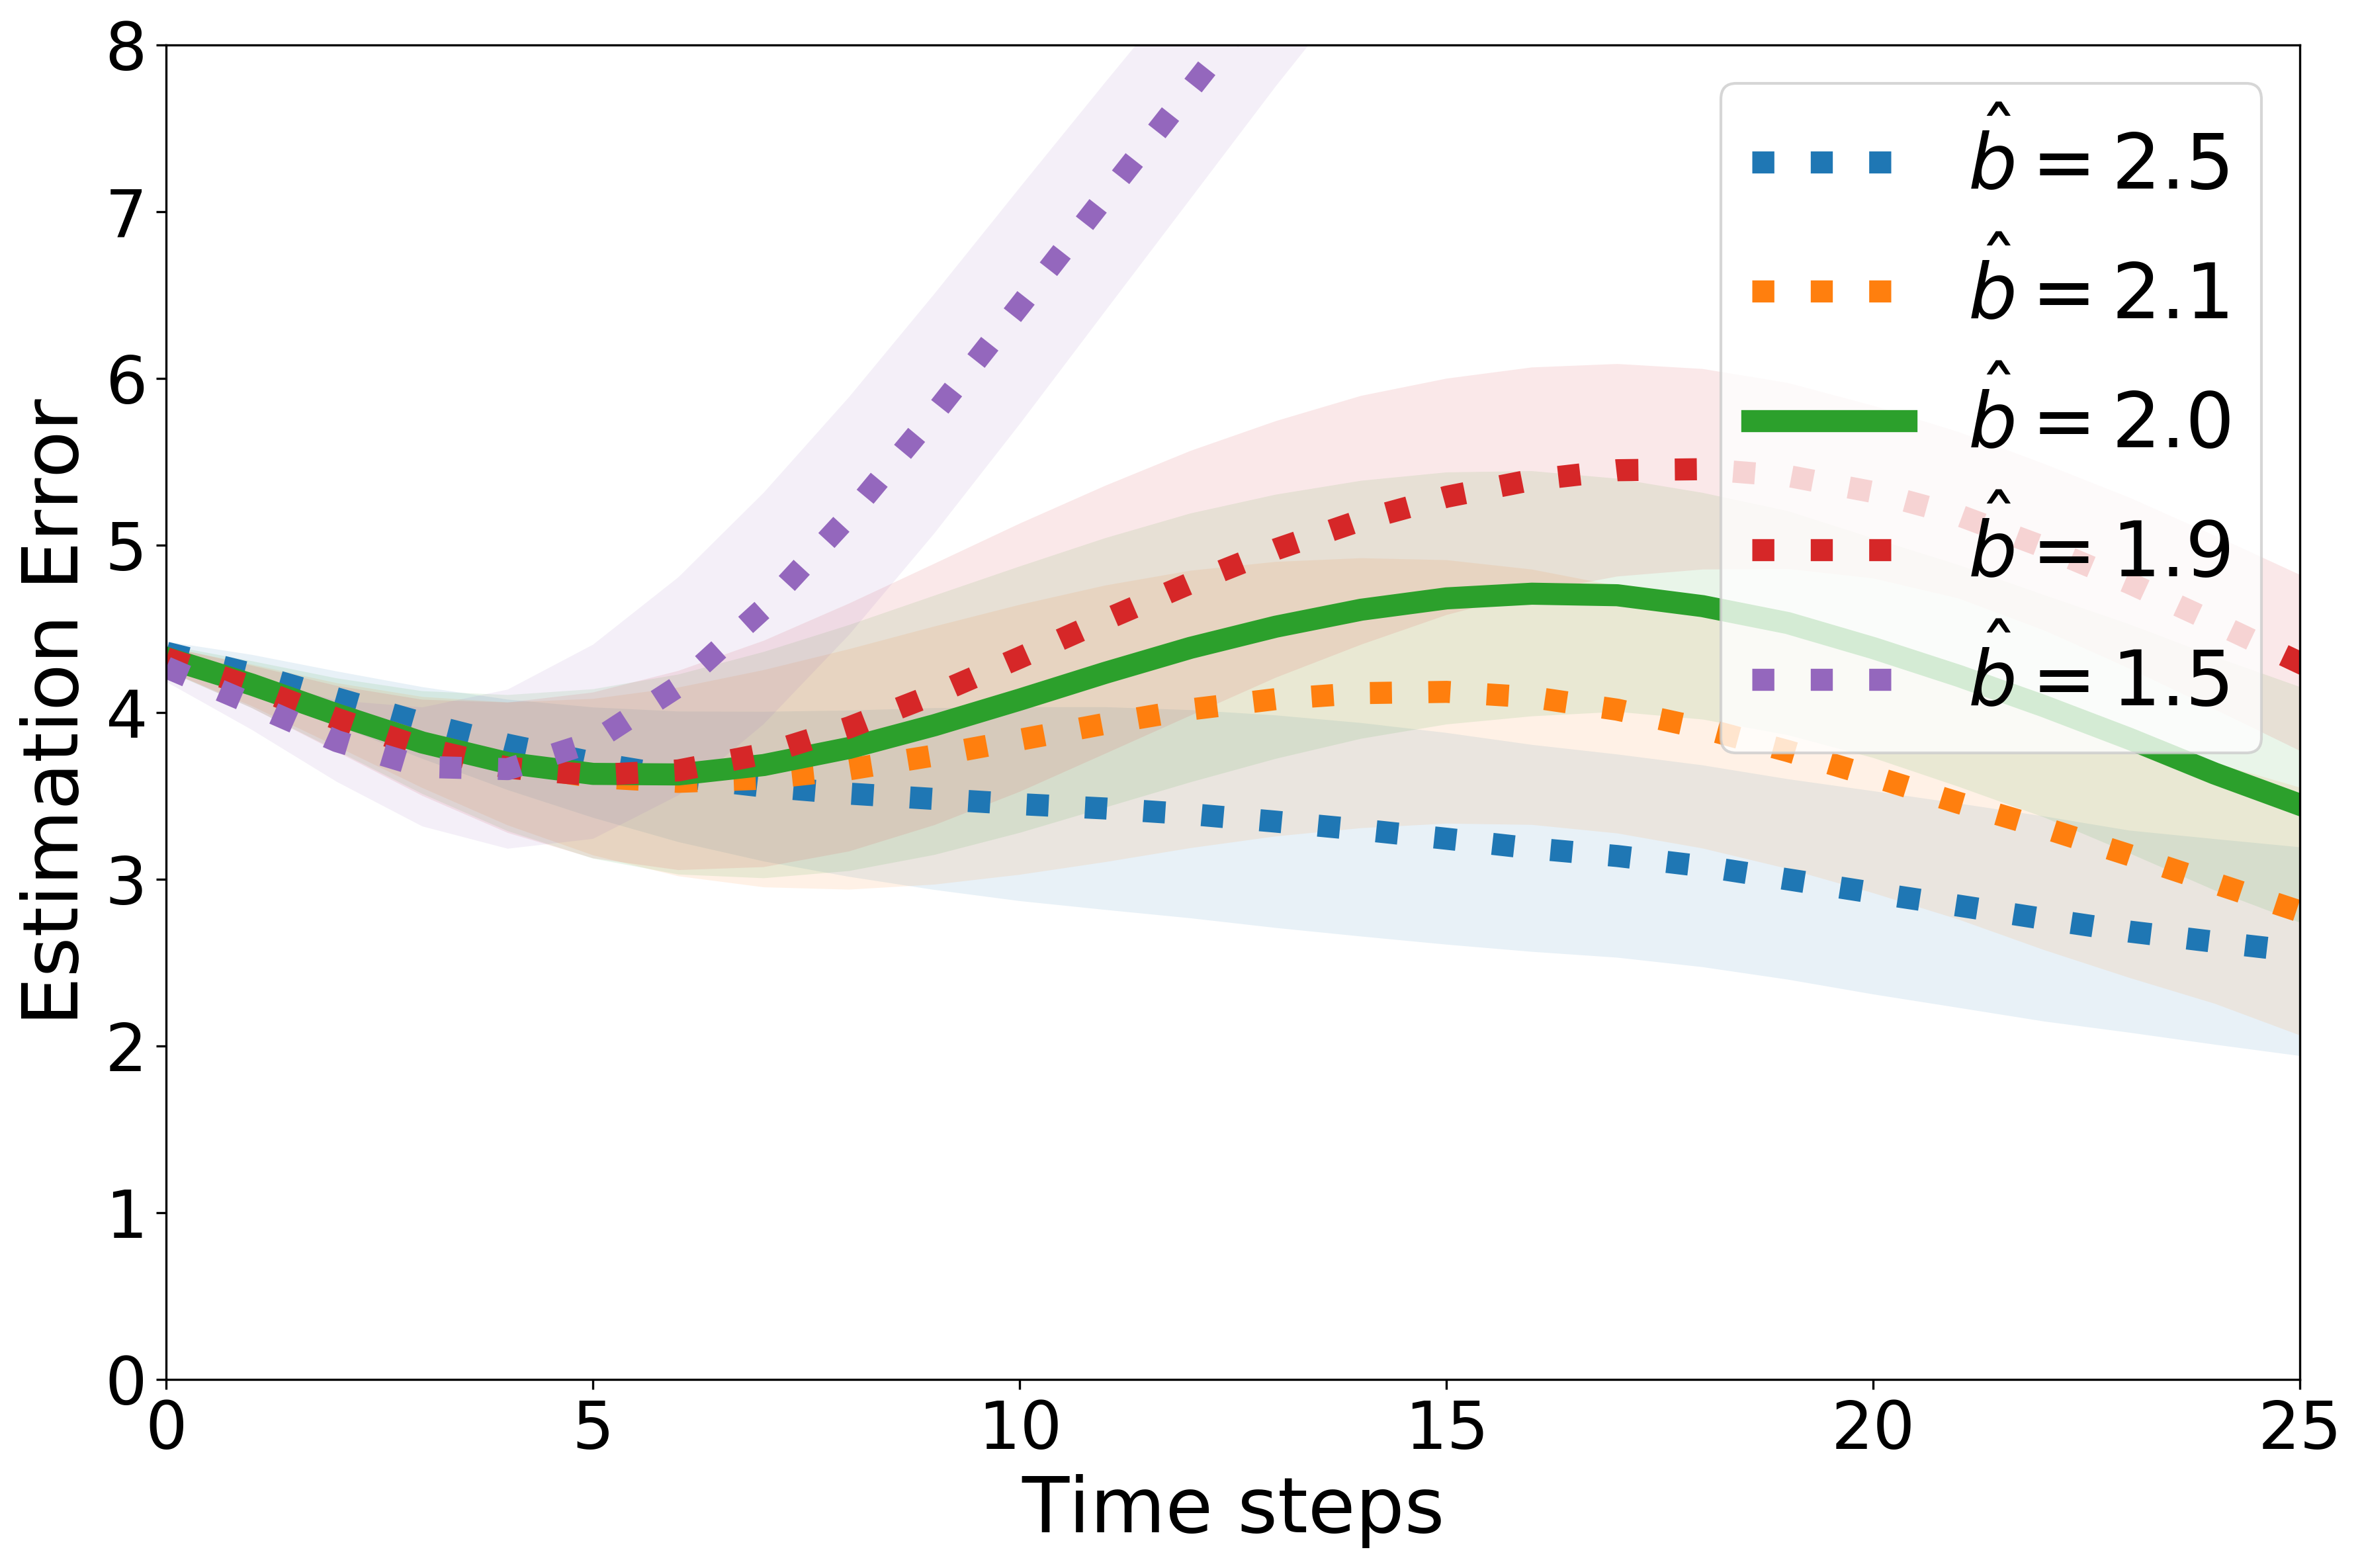

In [18]:
filepath = "RobustnessStationary.pkl"
with open(filepath,'rb') as file:
    errs = pkl.load(file)
plt.figure(dpi=300,figsize=(12,8))
for db,err in errs.items():
#     if db!=-0.1:
        mse = np.mean(err,axis=0)
        std = np.std(err,axis=0)
        x = range(len(mse))
        if db==0:
            plt.plot(x, mse,label=r'$\hat{b}=$'+'{}'.format(2-db),linewidth=8)
        else:
            plt.plot(x, mse,linestyle = 'dotted',label=r'$\hat{b}=$'+'{}'.format(-(-2+db)),linewidth=8)
        plt.fill_between(x, mse-std, mse+std,alpha=0.1)
# plt.title("Moving Sensors, Static Source\n Free Movement")
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim((0,8))
plt.xlim((0,25))
plt.xlabel("Time steps",fontsize=28)
plt.ylabel("Estimation Error",fontsize=28)
plt.legend(ncol = 1,fontsize=28)
plt.tight_layout()
plt.savefig("RobustnessStationary.png".format(noise_std))
plt.show()